Tenemos 40 carpetas (s1, s2, ..., s40) con 10 imágenes (1.png, 2.png, ..., 10.png) cada una. Las imágenes son de 112 x 92 en escala de grises normalizado (0-1).

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from random import randint
from numpy.linalg import inv, pinv

Podemos ver algunos ejemplos

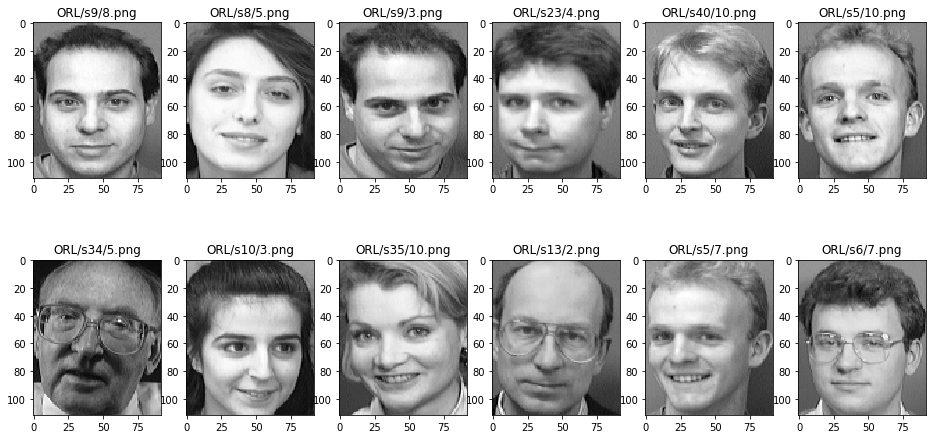

In [113]:
fig = plt.figure(figsize=(16,8))
c, r = 6, 2
for i in range(1, c*r +1):
    fig.add_subplot(r,c,i)
    path = "ORL/s"+str(randint(1, 40))+"/"+str(randint(1, 10))+".png"
    image = plt.imread(path)
    plt.imshow(image, cmap='gray')
    plt.title(path)
plt.show()

Leemos las imágenes de entrenamiento (1-5 de cada carpeta) y test (6-10 de cada carpeta).

In [114]:
samples = 40*5 # n = 200
size= 112*92 # d = 10304
x_train, y_train = np.zeros((size, samples)), np.zeros(samples)
x_test, y_test = np.zeros((size, samples)), np.zeros(samples)

In [115]:
for i in range(0,40):
    folder = "ORL/s"+str(i+1)
    for j in range(0,5):
        path = folder + "/"+str(j+1)+".png"
        image = plt.imread(path)
        x_train[:,i*5+j] = np.asarray(image).reshape(size)
        y_train[i*5+j] = i+1
        path = folder + "/"+str(j+6)+".png"
        image = plt.imread(path)
        x_test[:,i*5+j] = np.asarray(image).reshape(size)
        y_test[i*5+j] = i+1

Calculamos la cara media con las imágenes de entrenamiento.

In [116]:
mu = x_train.mean(axis=1).reshape((size,1))
meanFace = mu.reshape((112,92))

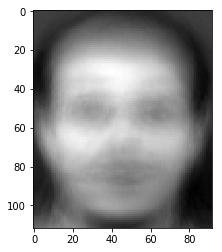

In [117]:
fig, ax = plt.subplots()
im = ax.imshow(meanFace, cmap='gray')
plt.show()

Matriz A

In [118]:
A = x_train - mu
A.shape # d x n

(10304, 200)

Matriz de covariancia

In [119]:
#C = np.dot(A,A.T)/samples # d x d -> muy costoso
Cp = np.matmul(A.T,A)/size # n x n -> asequible

In [120]:
Cp.shape # n x n

(200, 200)

Calculamos vectores y valores propios.

In [121]:
Lp, Bp = LA.eig(Cp)

In [122]:
B = np.matmul(A,Bp)
L = (size/samples)*Lp

Normalizar eigenvectors

In [123]:
B_norm = B/LA.norm(B,axis=0)
LA.norm(B_norm,axis=0).sum()/samples # 1

0.99999999999999967

Podemos ver cada eigenvector como una cara -> eigenfaces

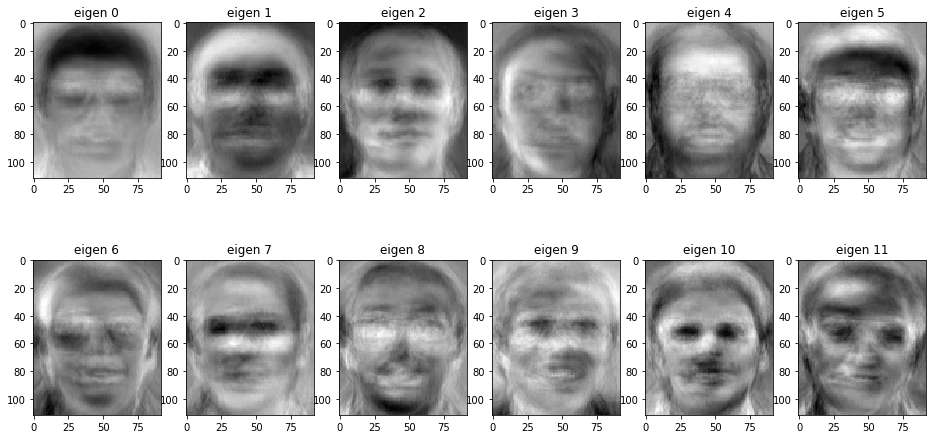

In [124]:
fig = plt.figure(figsize=(16,8))
c, r = 6, 2
for i in range(1, c*r +1):
    fig.add_subplot(r,c,i)
    plt.imshow(B_norm[:,i-1].reshape((112,92)), cmap='gray')
    plt.title("eigen "+str(i-1))
plt.show()

Nuevo espacio de representación (d x n) -> (dp x n) usando los dp eigenvectores mayores.

In [125]:
dp = 10
Bd = B_norm[:,:dp]
Bd.shape

(10304, 10)

In [126]:
x_train_PCA = np.matmul(Bd.T,x_train - mu)
x_test_PCA = np.matmul(Bd.T,x_test - mu)
x_train_PCA.shape

(10, 200)

# LDA

Calculamos las scatter matrices (en el nuevo espacio reducido !)

In [127]:
mu = x_train_PCA.mean(axis=1).reshape((dp,1))
mu.shape

(10, 1)

In [128]:
mu_c = np.zeros((dp,40))
for i in range(40):
    mu_c[:,i] =  x_train_PCA[:,i*5:(i+1)*5].mean(axis=1)
mu_c.shape

(10, 40)

In [129]:
Sb = np.zeros((dp,dp))
for i in range(40):
    Sb = Sb + 5*np.matmul((mu_c[:,i] - mu),(mu_c[:,i] - mu).T)
Sb.shape

(10, 10)

In [130]:
Sw = np.zeros((dp,dp))
for i in range(40):
    for j in range(5):
        Sw = Sw + np.matmul((x_train_PCA[:,i*5+j] - mu_c[:,i]),(x_train_PCA[:,i*5+j] - mu_c[:,i]).T)
Sw.shape

(10, 10)

In [131]:
#C = inv(Sw)*Sb
C = pinv(Sw)*Sb

In [132]:
L, B = LA.eig(C)
B.shape

(10, 10)

In [133]:
dpp = 5 # dpp < dp !
Bdd = B[:,:dpp]
Bdd.shape

(10, 5)

In [134]:
x_train_LDA = np.matmul(Bdd.T,x_train_PCA)
x_test_LDA = np.matmul(Bdd.T,x_test_PCA)
x_train_LDA.shape

(5, 200)

Clasificamos con vecinos más cercanos

In [135]:
from sklearn.neighbors import KNeighborsClassifier

In [136]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(x_train_LDA.T, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(x_train_LDA.T, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(x_test_LDA.T, y_test)))

Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.68


In [137]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = knn.predict(x_test_LDA.T)
#print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

        1.0       1.00      0.80      0.89         5
        2.0       0.40      0.80      0.53         5
        3.0       0.60      0.60      0.60         5
        4.0       0.60      0.60      0.60         5
        5.0       0.71      1.00      0.83         5
        6.0       1.00      1.00      1.00         5
        7.0       0.83      1.00      0.91         5
        8.0       1.00      1.00      1.00         5
        9.0       1.00      0.60      0.75         5
       10.0       0.80      0.80      0.80         5
       11.0       1.00      0.40      0.57         5
       12.0       0.38      0.60      0.46         5
       13.0       1.00      0.80      0.89         5
       14.0       0.00      0.00      0.00         5
       15.0       0.50      1.00      0.67         5
       16.0       0.67      0.40      0.50         5
       17.0       0.00      0.00      0.00         5
       18.0       0.80      0.80      0.80   

C:\Users\Sensio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
